In [1]:
# %%
import os
import numpy as np
import pandas as pd
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Masking
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow.keras.backend as K
import time

# %%
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# %%
#### Change inputs
modelID = '93jx'
## noaa stations following same order of the outputs
NOAAstations = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville']

#### Define paths and load data
# pathData = Path(r'../../../data/random_split')
pathData = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/inputs/random_split')
# pathColSample = pathData.parent
pathColSample = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
X_train_file = 'X_train_standardScaled_allInputs_augmentedAllX50_def.npy'
Y_train_file = 'y_train_augmentedAllX50_def.npy'
X_test_file = 'X_test_standardScaled_allInputs_augmentedAllX50_def.npy'
Y_test_file = 'y_test_augmentedAllX50_def.npy'

#### some hyperparameters
batch_size = 100
epochs = 1000
fold = 1 ## no cross validation


/home/tacuevas/miniconda3/envs/tf2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-04 15:41:32.161676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 15:41:34.007696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tacuevas/miniconda3/envs/tf2/lib/
2024-01-04 15:41:34.008111: W tensorflow/compiler/xla/stream_executor/platform

In [5]:
#### path to store outputs
#pathOut0 = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/81')
pathOut = Path(f'../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/{modelID}')
#pathOut0 = pathOut0/st

#### class to save best model
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, pathout, fold, modelID):
        super(CustomCallback, self).__init__()
        self.pathout = pathout
        self.fold = fold
        self.modelID = modelID
        self.previous_val_loss = float('inf')  # Initialize with a high value
        self.best_epoch = None
        self.best_model = None
    
    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.previous_val_loss:
            self.model.save(self.pathout / f'bestModel_{self.modelID}_fold{self.fold}.tf')
            self.previous_val_loss = current_val_loss
            self.best_epoch = epoch
            self.best_model = self.model
            with open(self.pathout / f'best_model.txt', 'a') as fout:
                fout.write(f'Best model saved for fold {self.fold}: epoch {self.best_epoch}, val_loss: {current_val_loss:0.3f}\n')

#### load data
X_train = np.load(pathData/X_train_file)
y_train = np.load(pathData/Y_train_file)
X_test = np.load(pathData/X_test_file)
y_test = np.load(pathData/Y_test_file)

#### train/validation split
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### pathout
#pathOut = pathOut0/st

columns_sample = pd.read_csv(pathColSample/'dct_tracksAll_batch02_lengthCorr_tides_resampled_SAMPLE.csv', index_col = 0)

# inputs
cols = ['wind_speed', 'pressure', 'rad_to_max_ws', 'forward_speed_u', 'forward_speed_v',
            'dist_to_duck', 'dist_to_oregon', 'dist_to_hatteras', 'dist_to_beaufort', 'dist_to_wilmington', 'dist_to_wrightsville', 'Boundary', 
            'wind_speed_fft', 'pressure_fft', 'rad_to_max_ws_fft',
            'forward_speed_u_fft', 'forward_speed_v_fft']

In [6]:
## extract inputs idx from the full input array
idx_cols = [list(columns_sample).index(x) for x in cols]
X_train_sub2 = X_train_sub[:, :, idx_cols]
X_val2 = X_val[:, :, idx_cols]
X_test2 = X_test[:, :, idx_cols]

In [7]:
try:
    os.mkdir(pathOut)
except:
    pass

#### Define model
model = Sequential([
                Masking(-9999, input_shape=(X_train_sub2.shape[1:])),
                Conv1D(16, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(32, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(64, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(64, activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.2),
                Dense(6, activation='relu'),
            ])

optimizer = RMSprop(learning_rate = 1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), 
                metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

#### callback to save model with lower val_loss
callback = CustomCallback(pathOut, fold=fold, modelID=modelID)
#### train the model
t0 = time.time()
history = model.fit(X_train_sub2, y_train_sub, batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data = (X_val2, y_val), callbacks=[callback])
print(f'Training time: {(time.time() - t0)/3600:0.3f} hrs')

#### save outputs
dfhist = pd.DataFrame.from_dict(history.history)
dfhist.to_csv(pathOut/f'history_{modelID}_fold{fold}.csv')

2024-01-04 15:43:46.558170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 15:43:48.373261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4356 MB memory:  -> device: 0, name: Quadro P2000, pci bus id: 0000:5b:00.0, compute capability: 6.1
2024-01-04 15:43:48.374475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 3452 MB memory:  -> device: 1, name: Quadro P2000, pci bus id: 0000:9e:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 235, 17)           0         
                                                                 
 conv1d (Conv1D)             (None, 233, 16)           832       
                                                                 
 batch_normalization (BatchN  (None, 233, 16)          64        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 116, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 114, 32)           1568      
                                                                 
 batch_normalization_1 (Batc  (None, 114, 32)          1

2024-01-04 15:43:53.871068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-01-04 15:43:54.750872: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 15:43:55.642052: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f90a400c850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 15:43:55.642146: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-01-04 15:43:55.642172: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro P2000, Compute Capability 6.1
2024-01-04 15:43:55.672650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-04 15:43:55.896114: I tensorflow/tsl/platform/default/subprocess.cc

629/629 [==============================] - ETA: 0s - loss: 0.1764 - mse: 0.4005 - mae: 0.4547 - rmse: 0.6329

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 23s 26ms/step - loss: 0.1764 - mse: 0.4005 - mae: 0.4547 - rmse: 0.6329 - val_loss: 0.1057 - val_mse: 0.2313 - val_mae: 0.3248 - val_rmse: 0.4810
Epoch 2/1000
629/629 [==============================] - ETA: 0s - loss: 0.1264 - mse: 0.2744 - mae: 0.3747 - rmse: 0.5238

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.1264 - mse: 0.2744 - mae: 0.3747 - rmse: 0.5238 - val_loss: 0.0907 - val_mse: 0.1937 - val_mae: 0.2994 - val_rmse: 0.4402
Epoch 3/1000
628/629 [============================>.] - ETA: 0s - loss: 0.1057 - mse: 0.2261 - mae: 0.3370 - rmse: 0.4755

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.1057 - mse: 0.2261 - mae: 0.3370 - rmse: 0.4755 - val_loss: 0.0726 - val_mse: 0.1536 - val_mae: 0.2607 - val_rmse: 0.3920
Epoch 4/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0907 - mse: 0.1927 - mae: 0.3072 - rmse: 0.4390

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0906 - mse: 0.1927 - mae: 0.3072 - rmse: 0.4389 - val_loss: 0.0633 - val_mse: 0.1325 - val_mae: 0.2435 - val_rmse: 0.3640
Epoch 5/1000
629/629 [==============================] - ETA: 0s - loss: 0.0812 - mse: 0.1712 - mae: 0.2889 - rmse: 0.4137

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0812 - mse: 0.1712 - mae: 0.2889 - rmse: 0.4137 - val_loss: 0.0606 - val_mse: 0.1273 - val_mae: 0.2352 - val_rmse: 0.3568
Epoch 6/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0744 - mse: 0.1562 - mae: 0.2746 - rmse: 0.3953

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0744 - mse: 0.1562 - mae: 0.2745 - rmse: 0.3952 - val_loss: 0.0584 - val_mse: 0.1219 - val_mae: 0.2308 - val_rmse: 0.3492
Epoch 7/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0687 - mse: 0.1436 - mae: 0.2631 - rmse: 0.3789

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0687 - mse: 0.1436 - mae: 0.2631 - rmse: 0.3789 - val_loss: 0.0515 - val_mse: 0.1065 - val_mae: 0.2183 - val_rmse: 0.3264
Epoch 8/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0632 - mse: 0.1317 - mae: 0.2517 - rmse: 0.3629

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0633 - mse: 0.1317 - mae: 0.2517 - rmse: 0.3630 - val_loss: 0.0461 - val_mse: 0.0946 - val_mae: 0.2100 - val_rmse: 0.3076
Epoch 9/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0589 - mse: 0.1221 - mae: 0.2431 - rmse: 0.3495

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0589 - mse: 0.1221 - mae: 0.2431 - rmse: 0.3494 - val_loss: 0.0422 - val_mse: 0.0864 - val_mae: 0.2023 - val_rmse: 0.2940
Epoch 10/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0554 - mse: 0.1144 - mae: 0.2358 - rmse: 0.3382 - val_loss: 0.0426 - val_mse: 0.0873 - val_mae: 0.1997 - val_rmse: 0.2955
Epoch 11/1000
629/629 [==============================] - ETA: 0s - loss: 0.0520 - mse: 0.1069 - mae: 0.2284 - rmse: 0.3269

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0520 - mse: 0.1069 - mae: 0.2284 - rmse: 0.3269 - val_loss: 0.0363 - val_mse: 0.0736 - val_mae: 0.1898 - val_rmse: 0.2714
Epoch 12/1000
626/629 [============================>.] - ETA: 0s - loss: 0.0492 - mse: 0.1010 - mae: 0.2225 - rmse: 0.3178

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0492 - mse: 0.1010 - mae: 0.2225 - rmse: 0.3177 - val_loss: 0.0331 - val_mse: 0.0667 - val_mae: 0.1839 - val_rmse: 0.2583
Epoch 13/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0475 - mse: 0.0973 - mae: 0.2187 - rmse: 0.3119 - val_loss: 0.0341 - val_mse: 0.0690 - val_mae: 0.1836 - val_rmse: 0.2627
Epoch 14/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0455 - mse: 0.0929 - mae: 0.2138 - rmse: 0.3049 - val_loss: 0.0343 - val_mse: 0.0693 - val_mae: 0.1834 - val_rmse: 0.2632
Epoch 15/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0437 - mse: 0.0891 - mae: 0.2099 - rmse: 0.2985

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0437 - mse: 0.0891 - mae: 0.2099 - rmse: 0.2985 - val_loss: 0.0310 - val_mse: 0.0626 - val_mae: 0.1760 - val_rmse: 0.2502
Epoch 16/1000
629/629 [==============================] - ETA: 0s - loss: 0.0424 - mse: 0.0864 - mae: 0.2066 - rmse: 0.2939

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0424 - mse: 0.0864 - mae: 0.2066 - rmse: 0.2939 - val_loss: 0.0307 - val_mse: 0.0620 - val_mae: 0.1740 - val_rmse: 0.2489
Epoch 17/1000
629/629 [==============================] - ETA: 0s - loss: 0.0412 - mse: 0.0839 - mae: 0.2037 - rmse: 0.2896

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0412 - mse: 0.0839 - mae: 0.2037 - rmse: 0.2896 - val_loss: 0.0277 - val_mse: 0.0556 - val_mae: 0.1694 - val_rmse: 0.2358
Epoch 18/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0404 - mse: 0.0823 - mae: 0.2015 - rmse: 0.2868 - val_loss: 0.0291 - val_mse: 0.0584 - val_mae: 0.1719 - val_rmse: 0.2417
Epoch 19/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0391 - mse: 0.0795 - mae: 0.1983 - rmse: 0.2820

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0391 - mse: 0.0795 - mae: 0.1983 - rmse: 0.2820 - val_loss: 0.0266 - val_mse: 0.0534 - val_mae: 0.1652 - val_rmse: 0.2310
Epoch 20/1000
629/629 [==============================] - ETA: 0s - loss: 0.0383 - mse: 0.0777 - mae: 0.1961 - rmse: 0.2787

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0383 - mse: 0.0777 - mae: 0.1961 - rmse: 0.2787 - val_loss: 0.0246 - val_mse: 0.0493 - val_mae: 0.1612 - val_rmse: 0.2221
Epoch 21/1000
629/629 [==============================] - ETA: 0s - loss: 0.0374 - mse: 0.0759 - mae: 0.1936 - rmse: 0.2755

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0374 - mse: 0.0759 - mae: 0.1936 - rmse: 0.2755 - val_loss: 0.0234 - val_mse: 0.0468 - val_mae: 0.1582 - val_rmse: 0.2164
Epoch 22/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0368 - mse: 0.0748 - mae: 0.1918 - rmse: 0.2735 - val_loss: 0.0245 - val_mse: 0.0492 - val_mae: 0.1598 - val_rmse: 0.2218
Epoch 23/1000
629/629 [==============================] - ETA: 0s - loss: 0.0361 - mse: 0.0733 - mae: 0.1899 - rmse: 0.2707

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0361 - mse: 0.0733 - mae: 0.1899 - rmse: 0.2707 - val_loss: 0.0227 - val_mse: 0.0455 - val_mae: 0.1550 - val_rmse: 0.2132
Epoch 24/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0352 - mse: 0.0712 - mae: 0.1879 - rmse: 0.2669 - val_loss: 0.0252 - val_mse: 0.0505 - val_mae: 0.1611 - val_rmse: 0.2247
Epoch 25/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0345 - mse: 0.0699 - mae: 0.1861 - rmse: 0.2644

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0345 - mse: 0.0699 - mae: 0.1861 - rmse: 0.2644 - val_loss: 0.0213 - val_mse: 0.0427 - val_mae: 0.1516 - val_rmse: 0.2067
Epoch 26/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0341 - mse: 0.0690 - mae: 0.1847 - rmse: 0.2628 - val_loss: 0.0228 - val_mse: 0.0456 - val_mae: 0.1547 - val_rmse: 0.2136
Epoch 27/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0336 - mse: 0.0680 - mae: 0.1831 - rmse: 0.2607 - val_loss: 0.0221 - val_mse: 0.0442 - val_mae: 0.1538 - val_rmse: 0.2103
Epoch 28/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0330 - mse: 0.0667 - mae: 0.1816 - rmse: 0.2583

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0330 - mse: 0.0667 - mae: 0.1816 - rmse: 0.2583 - val_loss: 0.0198 - val_mse: 0.0395 - val_mae: 0.1468 - val_rmse: 0.1988
Epoch 29/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0324 - mse: 0.0656 - mae: 0.1802 - rmse: 0.2562 - val_loss: 0.0217 - val_mse: 0.0434 - val_mae: 0.1503 - val_rmse: 0.2083
Epoch 30/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0321 - mse: 0.0649 - mae: 0.1789 - rmse: 0.2548 - val_loss: 0.0215 - val_mse: 0.0429 - val_mae: 0.1507 - val_rmse: 0.2072
Epoch 31/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0316 - mse: 0.0640 - mae: 0.1780 - rmse: 0.2529 - val_loss: 0.0201 - val_mse: 0.0403 - val_mae: 0.1467 - val_rmse: 0.2007
Epoch 32/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0312 - mse: 0.0630 - mae: 0.1766 - rmse: 0.2509 - val_loss: 0.0206 - val_mse: 0.0412 - val_mae: 0.1472 - val_rmse: 0.2029

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0308 - mse: 0.0624 - mae: 0.1755 - rmse: 0.2497 - val_loss: 0.0187 - val_mse: 0.0374 - val_mae: 0.1424 - val_rmse: 0.1933
Epoch 34/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0307 - mse: 0.0620 - mae: 0.1750 - rmse: 0.2489 - val_loss: 0.0191 - val_mse: 0.0382 - val_mae: 0.1428 - val_rmse: 0.1954
Epoch 35/1000
629/629 [==============================] - ETA: 0s - loss: 0.0304 - mse: 0.0613 - mae: 0.1741 - rmse: 0.2477

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0304 - mse: 0.0613 - mae: 0.1741 - rmse: 0.2477 - val_loss: 0.0183 - val_mse: 0.0367 - val_mae: 0.1414 - val_rmse: 0.1915
Epoch 36/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0299 - mse: 0.0603 - mae: 0.1729 - rmse: 0.2456 - val_loss: 0.0186 - val_mse: 0.0372 - val_mae: 0.1418 - val_rmse: 0.1929
Epoch 37/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0295 - mse: 0.0596 - mae: 0.1716 - rmse: 0.2442 - val_loss: 0.0184 - val_mse: 0.0367 - val_mae: 0.1409 - val_rmse: 0.1916
Epoch 38/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0291 - mse: 0.0588 - mae: 0.1707 - rmse: 0.2426 - val_loss: 0.0199 - val_mse: 0.0397 - val_mae: 0.1444 - val_rmse: 0.1993
Epoch 39/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0290 - mse: 0.0586 - mae: 0.1701 - rmse: 0.2420

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0290 - mse: 0.0585 - mae: 0.1701 - rmse: 0.2419 - val_loss: 0.0174 - val_mse: 0.0347 - val_mae: 0.1378 - val_rmse: 0.1863
Epoch 40/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0286 - mse: 0.0576 - mae: 0.1691 - rmse: 0.2400 - val_loss: 0.0203 - val_mse: 0.0406 - val_mae: 0.1448 - val_rmse: 0.2014
Epoch 41/1000
629/629 [==============================] - ETA: 0s - loss: 0.0284 - mse: 0.0573 - mae: 0.1683 - rmse: 0.2395

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0284 - mse: 0.0573 - mae: 0.1683 - rmse: 0.2395 - val_loss: 0.0169 - val_mse: 0.0337 - val_mae: 0.1357 - val_rmse: 0.1836
Epoch 42/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0282 - mse: 0.0569 - mae: 0.1677 - rmse: 0.2385

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0282 - mse: 0.0569 - mae: 0.1677 - rmse: 0.2385 - val_loss: 0.0164 - val_mse: 0.0329 - val_mae: 0.1345 - val_rmse: 0.1814
Epoch 43/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0279 - mse: 0.0564 - mae: 0.1671 - rmse: 0.2374 - val_loss: 0.0171 - val_mse: 0.0341 - val_mae: 0.1362 - val_rmse: 0.1848
Epoch 44/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0278 - mse: 0.0561 - mae: 0.1665 - rmse: 0.2369 - val_loss: 0.0175 - val_mse: 0.0350 - val_mae: 0.1369 - val_rmse: 0.1872
Epoch 45/1000
626/629 [============================>.] - ETA: 0s - loss: 0.0276 - mse: 0.0556 - mae: 0.1659 - rmse: 0.2358

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0276 - mse: 0.0556 - mae: 0.1659 - rmse: 0.2358 - val_loss: 0.0162 - val_mse: 0.0323 - val_mae: 0.1332 - val_rmse: 0.1798
Epoch 46/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0273 - mse: 0.0551 - mae: 0.1650 - rmse: 0.2347 - val_loss: 0.0174 - val_mse: 0.0349 - val_mae: 0.1360 - val_rmse: 0.1868
Epoch 47/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0272 - mse: 0.0549 - mae: 0.1646 - rmse: 0.2342 - val_loss: 0.0162 - val_mse: 0.0324 - val_mae: 0.1326 - val_rmse: 0.1801
Epoch 48/1000
629/629 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0543 - mae: 0.1638 - rmse: 0.2331

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0269 - mse: 0.0543 - mae: 0.1638 - rmse: 0.2331 - val_loss: 0.0161 - val_mse: 0.0322 - val_mae: 0.1325 - val_rmse: 0.1794
Epoch 49/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0265 - mse: 0.0535 - mae: 0.1626 - rmse: 0.2313 - val_loss: 0.0169 - val_mse: 0.0337 - val_mae: 0.1339 - val_rmse: 0.1837
Epoch 50/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0267 - mse: 0.0539 - mae: 0.1631 - rmse: 0.2323 - val_loss: 0.0169 - val_mse: 0.0337 - val_mae: 0.1343 - val_rmse: 0.1837
Epoch 51/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0264 - mse: 0.0532 - mae: 0.1620 - rmse: 0.2306

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0264 - mse: 0.0532 - mae: 0.1620 - rmse: 0.2306 - val_loss: 0.0156 - val_mse: 0.0311 - val_mae: 0.1299 - val_rmse: 0.1764
Epoch 52/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0263 - mse: 0.0530 - mae: 0.1613 - rmse: 0.2302 - val_loss: 0.0160 - val_mse: 0.0319 - val_mae: 0.1312 - val_rmse: 0.1787
Epoch 53/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0262 - mse: 0.0528 - mae: 0.1613 - rmse: 0.2298

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0262 - mse: 0.0528 - mae: 0.1613 - rmse: 0.2299 - val_loss: 0.0152 - val_mse: 0.0304 - val_mae: 0.1289 - val_rmse: 0.1744
Epoch 54/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0259 - mse: 0.0521 - mae: 0.1605 - rmse: 0.2283 - val_loss: 0.0161 - val_mse: 0.0322 - val_mae: 0.1313 - val_rmse: 0.1795
Epoch 55/1000
629/629 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0520 - mae: 0.1600 - rmse: 0.2280

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0258 - mse: 0.0520 - mae: 0.1600 - rmse: 0.2280 - val_loss: 0.0143 - val_mse: 0.0286 - val_mae: 0.1256 - val_rmse: 0.1692
Epoch 56/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0254 - mse: 0.0512 - mae: 0.1591 - rmse: 0.2263 - val_loss: 0.0150 - val_mse: 0.0300 - val_mae: 0.1282 - val_rmse: 0.1731
Epoch 57/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0254 - mse: 0.0511 - mae: 0.1589 - rmse: 0.2261

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0254 - mse: 0.0511 - mae: 0.1589 - rmse: 0.2261 - val_loss: 0.0142 - val_mse: 0.0284 - val_mae: 0.1258 - val_rmse: 0.1685
Epoch 58/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0254 - mse: 0.0511 - mae: 0.1587 - rmse: 0.2260 - val_loss: 0.0147 - val_mse: 0.0295 - val_mae: 0.1264 - val_rmse: 0.1716
Epoch 59/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0254 - mse: 0.0513 - mae: 0.1585 - rmse: 0.2265

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0254 - mse: 0.0513 - mae: 0.1585 - rmse: 0.2265 - val_loss: 0.0141 - val_mse: 0.0282 - val_mae: 0.1249 - val_rmse: 0.1680
Epoch 60/1000
629/629 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0503 - mae: 0.1576 - rmse: 0.2242

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 22ms/step - loss: 0.0250 - mse: 0.0503 - mae: 0.1576 - rmse: 0.2242 - val_loss: 0.0138 - val_mse: 0.0276 - val_mae: 0.1238 - val_rmse: 0.1661
Epoch 61/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0249 - mse: 0.0503 - mae: 0.1574 - rmse: 0.2242 - val_loss: 0.0139 - val_mse: 0.0277 - val_mae: 0.1237 - val_rmse: 0.1665
Epoch 62/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0246 - mse: 0.0495 - mae: 0.1562 - rmse: 0.2225 - val_loss: 0.0139 - val_mse: 0.0278 - val_mae: 0.1234 - val_rmse: 0.1669
Epoch 63/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0246 - mse: 0.0495 - mae: 0.1562 - rmse: 0.2226 - val_loss: 0.0138 - val_mse: 0.0276 - val_mae: 0.1230 - val_rmse: 0.1662
Epoch 64/1000
629/629 [==============================] - 12s 19ms/step - loss: 0.0245 - mse: 0.0494 - mae: 0.1558 - rmse: 0.2223 - val_loss: 0.0154 - val_mse: 0.0309 - val_mae: 0.1276 - val_rmse: 0.1756

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0244 - mse: 0.0492 - mae: 0.1557 - rmse: 0.2218 - val_loss: 0.0134 - val_mse: 0.0268 - val_mae: 0.1212 - val_rmse: 0.1636
Epoch 66/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0243 - mse: 0.0489 - mae: 0.1553 - rmse: 0.2211 - val_loss: 0.0137 - val_mse: 0.0274 - val_mae: 0.1225 - val_rmse: 0.1655
Epoch 67/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0242 - mse: 0.0487 - mae: 0.1550 - rmse: 0.2206 - val_loss: 0.0138 - val_mse: 0.0277 - val_mae: 0.1230 - val_rmse: 0.1664
Epoch 68/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0240 - mse: 0.0482 - mae: 0.1542 - rmse: 0.2196 - val_loss: 0.0152 - val_mse: 0.0303 - val_mae: 0.1270 - val_rmse: 0.1741
Epoch 69/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0240 - mse: 0.0484 - mae: 0.1543 - rmse: 0.2199 - val_loss: 0.0138 - val_mse: 0.0276 - val_mae: 0.1230 - val_rmse: 0.1662

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0235 - mse: 0.0473 - mae: 0.1530 - rmse: 0.2175 - val_loss: 0.0134 - val_mse: 0.0267 - val_mae: 0.1215 - val_rmse: 0.1634
Epoch 72/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0237 - mse: 0.0477 - mae: 0.1533 - rmse: 0.2183

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0237 - mse: 0.0477 - mae: 0.1533 - rmse: 0.2183 - val_loss: 0.0126 - val_mse: 0.0252 - val_mae: 0.1187 - val_rmse: 0.1588
Epoch 73/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0236 - mse: 0.0476 - mae: 0.1530 - rmse: 0.2182 - val_loss: 0.0133 - val_mse: 0.0266 - val_mae: 0.1207 - val_rmse: 0.1631
Epoch 74/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0233 - mse: 0.0470 - mae: 0.1523 - rmse: 0.2167 - val_loss: 0.0131 - val_mse: 0.0262 - val_mae: 0.1195 - val_rmse: 0.1620
Epoch 75/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0233 - mse: 0.0468 - mae: 0.1521 - rmse: 0.2164 - val_loss: 0.0136 - val_mse: 0.0273 - val_mae: 0.1218 - val_rmse: 0.1652
Epoch 76/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0232 - mse: 0.0467 - mae: 0.1516 - rmse: 0.2161 - val_loss: 0.0153 - val_mse: 0.0307 - val_mae: 0.1262 - val_rmse: 0.1751

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0230 - mse: 0.0464 - mae: 0.1513 - rmse: 0.2153 - val_loss: 0.0124 - val_mse: 0.0249 - val_mae: 0.1180 - val_rmse: 0.1577
Epoch 80/1000
629/629 [==============================] - ETA: 0s - loss: 0.0230 - mse: 0.0463 - mae: 0.1511 - rmse: 0.2152

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0230 - mse: 0.0463 - mae: 0.1511 - rmse: 0.2152 - val_loss: 0.0122 - val_mse: 0.0244 - val_mae: 0.1162 - val_rmse: 0.1561
Epoch 81/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0228 - mse: 0.0460 - mae: 0.1502 - rmse: 0.2144 - val_loss: 0.0131 - val_mse: 0.0262 - val_mae: 0.1192 - val_rmse: 0.1617
Epoch 82/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0227 - mse: 0.0457 - mae: 0.1501 - rmse: 0.2138 - val_loss: 0.0130 - val_mse: 0.0259 - val_mae: 0.1197 - val_rmse: 0.1610
Epoch 83/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0226 - mse: 0.0455 - mae: 0.1497 - rmse: 0.2133 - val_loss: 0.0122 - val_mse: 0.0245 - val_mae: 0.1159 - val_rmse: 0.1565
Epoch 84/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0227 - mse: 0.0458 - mae: 0.1501 - rmse: 0.2139 - val_loss: 0.0123 - val_mse: 0.0247 - val_mae: 0.1165 - val_rmse: 0.1570

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0224 - mse: 0.0450 - mae: 0.1489 - rmse: 0.2122 - val_loss: 0.0113 - val_mse: 0.0226 - val_mae: 0.1125 - val_rmse: 0.1502
Epoch 87/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0224 - mse: 0.0450 - mae: 0.1488 - rmse: 0.2121 - val_loss: 0.0128 - val_mse: 0.0255 - val_mae: 0.1171 - val_rmse: 0.1598
Epoch 88/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0223 - mse: 0.0448 - mae: 0.1486 - rmse: 0.2117 - val_loss: 0.0118 - val_mse: 0.0235 - val_mae: 0.1141 - val_rmse: 0.1534
Epoch 89/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0222 - mse: 0.0447 - mae: 0.1482 - rmse: 0.2115 - val_loss: 0.0125 - val_mse: 0.0251 - val_mae: 0.1185 - val_rmse: 0.1583
Epoch 90/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0221 - mse: 0.0445 - mae: 0.1479 - rmse: 0.2109 - val_loss: 0.0131 - val_mse: 0.0261 - val_mae: 0.1182 - val_rmse: 0.1616

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0215 - mse: 0.0432 - mae: 0.1458 - rmse: 0.2079 - val_loss: 0.0108 - val_mse: 0.0216 - val_mae: 0.1097 - val_rmse: 0.1470
Epoch 102/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0213 - mse: 0.0429 - mae: 0.1453 - rmse: 0.2072 - val_loss: 0.0116 - val_mse: 0.0232 - val_mae: 0.1129 - val_rmse: 0.1522
Epoch 103/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0213 - mse: 0.0429 - mae: 0.1454 - rmse: 0.2071

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 14s 23ms/step - loss: 0.0213 - mse: 0.0429 - mae: 0.1454 - rmse: 0.2071 - val_loss: 0.0108 - val_mse: 0.0215 - val_mae: 0.1099 - val_rmse: 0.1467
Epoch 104/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0214 - mse: 0.0431 - mae: 0.1452 - rmse: 0.2076 - val_loss: 0.0123 - val_mse: 0.0246 - val_mae: 0.1151 - val_rmse: 0.1568
Epoch 105/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0213 - mse: 0.0429 - mae: 0.1450 - rmse: 0.2070 - val_loss: 0.0111 - val_mse: 0.0223 - val_mae: 0.1108 - val_rmse: 0.1493
Epoch 106/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0212 - mse: 0.0426 - mae: 0.1447 - rmse: 0.2064 - val_loss: 0.0120 - val_mse: 0.0241 - val_mae: 0.1153 - val_rmse: 0.1552
Epoch 107/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0213 - mse: 0.0429 - mae: 0.1449 - rmse: 0.2070 - val_loss: 0.0133 - val_mse: 0.0265 - val_mae: 0.1173 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0210 - mse: 0.0422 - mae: 0.1439 - rmse: 0.2054 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.1069 - val_rmse: 0.1421
Epoch 112/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0208 - mse: 0.0419 - mae: 0.1432 - rmse: 0.2047 - val_loss: 0.0108 - val_mse: 0.0216 - val_mae: 0.1095 - val_rmse: 0.1471
Epoch 113/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0207 - mse: 0.0416 - mae: 0.1432 - rmse: 0.2039 - val_loss: 0.0105 - val_mse: 0.0210 - val_mae: 0.1080 - val_rmse: 0.1449
Epoch 114/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0209 - mse: 0.0419 - mae: 0.1436 - rmse: 0.2048 - val_loss: 0.0140 - val_mse: 0.0280 - val_mae: 0.1198 - val_rmse: 0.1672
Epoch 115/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0209 - mse: 0.0421 - mae: 0.1436 - rmse: 0.2051 - val_loss: 0.0105 - val_mse: 0.0211 - val_mae: 0.1079 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0202 - mse: 0.0405 - mae: 0.1411 - rmse: 0.2013 - val_loss: 0.0097 - val_mse: 0.0193 - val_mae: 0.1039 - val_rmse: 0.1389
Epoch 130/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0200 - mse: 0.0402 - mae: 0.1406 - rmse: 0.2005 - val_loss: 0.0105 - val_mse: 0.0210 - val_mae: 0.1075 - val_rmse: 0.1448
Epoch 131/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0201 - mse: 0.0405 - mae: 0.1407 - rmse: 0.2012 - val_loss: 0.0097 - val_mse: 0.0194 - val_mae: 0.1042 - val_rmse: 0.1393
Epoch 132/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0200 - mse: 0.0402 - mae: 0.1405 - rmse: 0.2006 - val_loss: 0.0103 - val_mse: 0.0206 - val_mae: 0.1065 - val_rmse: 0.1435
Epoch 133/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0201 - mse: 0.0403 - mae: 0.1407 - rmse: 0.2008 - val_loss: 0.0099 - val_mse: 0.0198 - val_mae: 0.1049 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0194 - mse: 0.0390 - mae: 0.1386 - rmse: 0.1976 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.1023 - val_rmse: 0.1372
Epoch 147/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0195 - mse: 0.0391 - mae: 0.1386 - rmse: 0.1978 - val_loss: 0.0103 - val_mse: 0.0206 - val_mae: 0.1058 - val_rmse: 0.1436
Epoch 148/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0193 - mse: 0.0388 - mae: 0.1379 - rmse: 0.1971 - val_loss: 0.0100 - val_mse: 0.0201 - val_mae: 0.1051 - val_rmse: 0.1416
Epoch 149/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0196 - mse: 0.0393 - mae: 0.1385 - rmse: 0.1983 - val_loss: 0.0111 - val_mse: 0.0221 - val_mae: 0.1087 - val_rmse: 0.1488
Epoch 150/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0196 - mse: 0.0393 - mae: 0.1387 - rmse: 0.1983 - val_loss: 0.0099 - val_mse: 0.0198 - val_mae: 0.1043 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0193 - mse: 0.0387 - mae: 0.1376 - rmse: 0.1968 - val_loss: 0.0090 - val_mse: 0.0180 - val_mae: 0.1008 - val_rmse: 0.1343
Epoch 155/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0193 - mse: 0.0388 - mae: 0.1377 - rmse: 0.1970 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.1048 - val_rmse: 0.1420
Epoch 156/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0193 - mse: 0.0388 - mae: 0.1376 - rmse: 0.1969 - val_loss: 0.0096 - val_mse: 0.0191 - val_mae: 0.1027 - val_rmse: 0.1382
Epoch 157/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0191 - mse: 0.0385 - mae: 0.1372 - rmse: 0.1963 - val_loss: 0.0099 - val_mse: 0.0197 - val_mae: 0.1037 - val_rmse: 0.1404
Epoch 158/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0192 - mse: 0.0385 - mae: 0.1374 - rmse: 0.1963 - val_loss: 0.0110 - val_mse: 0.0220 - val_mae: 0.1081 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0189 - mse: 0.0378 - mae: 0.1361 - rmse: 0.1945 - val_loss: 0.0087 - val_mse: 0.0175 - val_mae: 0.0992 - val_rmse: 0.1323
Epoch 166/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0190 - mse: 0.0381 - mae: 0.1363 - rmse: 0.1952 - val_loss: 0.0097 - val_mse: 0.0195 - val_mae: 0.1033 - val_rmse: 0.1395
Epoch 167/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0189 - mse: 0.0378 - mae: 0.1363 - rmse: 0.1945 - val_loss: 0.0092 - val_mse: 0.0184 - val_mae: 0.1010 - val_rmse: 0.1358
Epoch 168/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0188 - mse: 0.0378 - mae: 0.1361 - rmse: 0.1944 - val_loss: 0.0088 - val_mse: 0.0175 - val_mae: 0.0995 - val_rmse: 0.1324
Epoch 169/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0189 - mse: 0.0380 - mae: 0.1363 - rmse: 0.1949 - val_loss: 0.0095 - val_mse: 0.0189 - val_mae: 0.1025 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0187 - mse: 0.0375 - mae: 0.1355 - rmse: 0.1937 - val_loss: 0.0086 - val_mse: 0.0172 - val_mae: 0.0982 - val_rmse: 0.1312
Epoch 176/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0186 - mse: 0.0373 - mae: 0.1351 - rmse: 0.1931 - val_loss: 0.0100 - val_mse: 0.0199 - val_mae: 0.1038 - val_rmse: 0.1412
Epoch 177/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0186 - mse: 0.0373 - mae: 0.1351 - rmse: 0.1932 - val_loss: 0.0088 - val_mse: 0.0176 - val_mae: 0.0990 - val_rmse: 0.1326
Epoch 178/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0186 - mse: 0.0373 - mae: 0.1352 - rmse: 0.1932 - val_loss: 0.0087 - val_mse: 0.0174 - val_mae: 0.0990 - val_rmse: 0.1319
Epoch 179/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0187 - mse: 0.0376 - mae: 0.1352 - rmse: 0.1938 - val_loss: 0.0101 - val_mse: 0.0203 - val_mae: 0.1042 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0183 - mse: 0.0368 - mae: 0.1343 - rmse: 0.1917 - val_loss: 0.0085 - val_mse: 0.0169 - val_mae: 0.0977 - val_rmse: 0.1301
Epoch 189/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0183 - mse: 0.0368 - mae: 0.1342 - rmse: 0.1919 - val_loss: 0.0099 - val_mse: 0.0198 - val_mae: 0.1037 - val_rmse: 0.1407
Epoch 190/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0182 - mse: 0.0366 - mae: 0.1339 - rmse: 0.1912 - val_loss: 0.0087 - val_mse: 0.0174 - val_mae: 0.0985 - val_rmse: 0.1320
Epoch 191/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0182 - mse: 0.0364 - mae: 0.1335 - rmse: 0.1909 - val_loss: 0.0096 - val_mse: 0.0192 - val_mae: 0.1021 - val_rmse: 0.1385
Epoch 192/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0183 - mse: 0.0367 - mae: 0.1338 - rmse: 0.1915 - val_loss: 0.0099 - val_mse: 0.0199 - val_mae: 0.1040 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0177 - mse: 0.0356 - mae: 0.1321 - rmse: 0.1888 - val_loss: 0.0083 - val_mse: 0.0166 - val_mae: 0.0966 - val_rmse: 0.1290
Epoch 209/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0178 - mse: 0.0358 - mae: 0.1323 - rmse: 0.1891 - val_loss: 0.0097 - val_mse: 0.0193 - val_mae: 0.1025 - val_rmse: 0.1389
Epoch 210/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0178 - mse: 0.0358 - mae: 0.1324 - rmse: 0.1892 - val_loss: 0.0085 - val_mse: 0.0170 - val_mae: 0.0970 - val_rmse: 0.1305
Epoch 211/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0180 - mse: 0.0361 - mae: 0.1325 - rmse: 0.1900 - val_loss: 0.0091 - val_mse: 0.0182 - val_mae: 0.0997 - val_rmse: 0.1349
Epoch 212/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0177 - mse: 0.0355 - mae: 0.1322 - rmse: 0.1885 - val_loss: 0.0087 - val_mse: 0.0174 - val_mae: 0.0984 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0177 - mse: 0.0356 - mae: 0.1319 - rmse: 0.1887 - val_loss: 0.0082 - val_mse: 0.0163 - val_mae: 0.0955 - val_rmse: 0.1277
Epoch 220/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0178 - mse: 0.0359 - mae: 0.1318 - rmse: 0.1895 - val_loss: 0.0107 - val_mse: 0.0214 - val_mae: 0.1060 - val_rmse: 0.1464
Epoch 221/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0177 - mse: 0.0356 - mae: 0.1316 - rmse: 0.1886 - val_loss: 0.0090 - val_mse: 0.0179 - val_mae: 0.0991 - val_rmse: 0.1338
Epoch 222/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0176 - mse: 0.0353 - mae: 0.1313 - rmse: 0.1878 - val_loss: 0.0084 - val_mse: 0.0169 - val_mae: 0.0971 - val_rmse: 0.1300
Epoch 223/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0175 - mse: 0.0351 - mae: 0.1309 - rmse: 0.1874 - val_loss: 0.0084 - val_mse: 0.0169 - val_mae: 0.0971 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0175 - mse: 0.0352 - mae: 0.1311 - rmse: 0.1876 - val_loss: 0.0078 - val_mse: 0.0157 - val_mae: 0.0943 - val_rmse: 0.1253
Epoch 226/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0176 - mse: 0.0353 - mae: 0.1313 - rmse: 0.1879 - val_loss: 0.0080 - val_mse: 0.0160 - val_mae: 0.0955 - val_rmse: 0.1267
Epoch 227/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0174 - mse: 0.0350 - mae: 0.1310 - rmse: 0.1871 - val_loss: 0.0094 - val_mse: 0.0189 - val_mae: 0.1015 - val_rmse: 0.1373
Epoch 228/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0174 - mse: 0.0350 - mae: 0.1309 - rmse: 0.1871 - val_loss: 0.0083 - val_mse: 0.0166 - val_mae: 0.0966 - val_rmse: 0.1290
Epoch 229/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0174 - mse: 0.0350 - mae: 0.1311 - rmse: 0.1870 - val_loss: 0.0082 - val_mse: 0.0164 - val_mae: 0.0955 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0171 - mse: 0.0344 - mae: 0.1297 - rmse: 0.1854 - val_loss: 0.0077 - val_mse: 0.0154 - val_mae: 0.0934 - val_rmse: 0.1241
Epoch 246/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0172 - mse: 0.0345 - mae: 0.1299 - rmse: 0.1858 - val_loss: 0.0090 - val_mse: 0.0181 - val_mae: 0.0996 - val_rmse: 0.1345
Epoch 247/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0172 - mse: 0.0345 - mae: 0.1299 - rmse: 0.1858 - val_loss: 0.0088 - val_mse: 0.0175 - val_mae: 0.0983 - val_rmse: 0.1325
Epoch 248/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0171 - mse: 0.0343 - mae: 0.1296 - rmse: 0.1853 - val_loss: 0.0077 - val_mse: 0.0155 - val_mae: 0.0938 - val_rmse: 0.1244
Epoch 249/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0171 - mse: 0.0344 - mae: 0.1296 - rmse: 0.1854 - val_loss: 0.0079 - val_mse: 0.0158 - val_mae: 0.0940 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0171 - mse: 0.0343 - mae: 0.1294 - rmse: 0.1851 - val_loss: 0.0076 - val_mse: 0.0152 - val_mae: 0.0927 - val_rmse: 0.1233
Epoch 254/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0171 - mse: 0.0343 - mae: 0.1292 - rmse: 0.1852 - val_loss: 0.0078 - val_mse: 0.0157 - val_mae: 0.0942 - val_rmse: 0.1252
Epoch 255/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0171 - mse: 0.0342 - mae: 0.1291 - rmse: 0.1850 - val_loss: 0.0080 - val_mse: 0.0160 - val_mae: 0.0946 - val_rmse: 0.1267
Epoch 256/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0170 - mse: 0.0341 - mae: 0.1291 - rmse: 0.1847 - val_loss: 0.0083 - val_mse: 0.0166 - val_mae: 0.0963 - val_rmse: 0.1289
Epoch 257/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0170 - mse: 0.0340 - mae: 0.1288 - rmse: 0.1845 - val_loss: 0.0079 - val_mse: 0.0158 - val_mae: 0.0945 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0165 - mse: 0.0330 - mae: 0.1269 - rmse: 0.1817 - val_loss: 0.0076 - val_mse: 0.0151 - val_mae: 0.0923 - val_rmse: 0.1231
Epoch 289/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0165 - mse: 0.0331 - mae: 0.1266 - rmse: 0.1819 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.1005 - val_rmse: 0.1371
Epoch 290/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0165 - mse: 0.0330 - mae: 0.1269 - rmse: 0.1818 - val_loss: 0.0086 - val_mse: 0.0171 - val_mae: 0.0969 - val_rmse: 0.1309
Epoch 291/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0164 - mse: 0.0329 - mae: 0.1265 - rmse: 0.1815 - val_loss: 0.0079 - val_mse: 0.0157 - val_mae: 0.0942 - val_rmse: 0.1255
Epoch 292/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0163 - mse: 0.0328 - mae: 0.1263 - rmse: 0.1810 - val_loss: 0.0087 - val_mse: 0.0175 - val_mae: 0.0977 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0164 - mse: 0.0329 - mae: 0.1264 - rmse: 0.1815 - val_loss: 0.0074 - val_mse: 0.0148 - val_mae: 0.0912 - val_rmse: 0.1217
Epoch 298/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0163 - mse: 0.0327 - mae: 0.1263 - rmse: 0.1809 - val_loss: 0.0078 - val_mse: 0.0156 - val_mae: 0.0938 - val_rmse: 0.1250
Epoch 299/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0163 - mse: 0.0328 - mae: 0.1263 - rmse: 0.1810 - val_loss: 0.0075 - val_mse: 0.0150 - val_mae: 0.0921 - val_rmse: 0.1226
Epoch 300/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0164 - mse: 0.0330 - mae: 0.1264 - rmse: 0.1816 - val_loss: 0.0080 - val_mse: 0.0160 - val_mae: 0.0947 - val_rmse: 0.1266
Epoch 301/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0164 - mse: 0.0328 - mae: 0.1261 - rmse: 0.1812 - val_loss: 0.0085 - val_mse: 0.0171 - val_mae: 0.0964 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0161 - mse: 0.0323 - mae: 0.1251 - rmse: 0.1796 - val_loss: 0.0072 - val_mse: 0.0145 - val_mae: 0.0907 - val_rmse: 0.1202
Epoch 322/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0161 - mse: 0.0323 - mae: 0.1251 - rmse: 0.1797 - val_loss: 0.0077 - val_mse: 0.0154 - val_mae: 0.0927 - val_rmse: 0.1241
Epoch 323/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0161 - mse: 0.0324 - mae: 0.1251 - rmse: 0.1799 - val_loss: 0.0076 - val_mse: 0.0151 - val_mae: 0.0925 - val_rmse: 0.1230
Epoch 324/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0161 - mse: 0.0323 - mae: 0.1252 - rmse: 0.1798 - val_loss: 0.0086 - val_mse: 0.0172 - val_mae: 0.0966 - val_rmse: 0.1313
Epoch 325/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0161 - mse: 0.0323 - mae: 0.1251 - rmse: 0.1798 - val_loss: 0.0083 - val_mse: 0.0166 - val_mae: 0.0954 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0160 - mse: 0.0321 - mae: 0.1245 - rmse: 0.1793 - val_loss: 0.0072 - val_mse: 0.0144 - val_mae: 0.0899 - val_rmse: 0.1201
Epoch 338/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0159 - mse: 0.0318 - mae: 0.1241 - rmse: 0.1784 - val_loss: 0.0080 - val_mse: 0.0161 - val_mae: 0.0945 - val_rmse: 0.1269
Epoch 339/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0161 - mse: 0.0323 - mae: 0.1250 - rmse: 0.1798 - val_loss: 0.0086 - val_mse: 0.0172 - val_mae: 0.0961 - val_rmse: 0.1310
Epoch 340/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0159 - mse: 0.0319 - mae: 0.1245 - rmse: 0.1785 - val_loss: 0.0084 - val_mse: 0.0168 - val_mae: 0.0953 - val_rmse: 0.1296
Epoch 341/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0159 - mse: 0.0318 - mae: 0.1241 - rmse: 0.1783 - val_loss: 0.0081 - val_mse: 0.0162 - val_mae: 0.0946 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0159 - mse: 0.0318 - mae: 0.1241 - rmse: 0.1784 - val_loss: 0.0072 - val_mse: 0.0143 - val_mae: 0.0901 - val_rmse: 0.1196
Epoch 345/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0159 - mse: 0.0319 - mae: 0.1243 - rmse: 0.1787 - val_loss: 0.0073 - val_mse: 0.0147 - val_mae: 0.0907 - val_rmse: 0.1212
Epoch 346/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0158 - mse: 0.0318 - mae: 0.1240 - rmse: 0.1782 - val_loss: 0.0100 - val_mse: 0.0201 - val_mae: 0.1019 - val_rmse: 0.1417
Epoch 347/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0159 - mse: 0.0319 - mae: 0.1243 - rmse: 0.1787 - val_loss: 0.0072 - val_mse: 0.0143 - val_mae: 0.0898 - val_rmse: 0.1196
Epoch 348/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0158 - mse: 0.0317 - mae: 0.1239 - rmse: 0.1781 - val_loss: 0.0081 - val_mse: 0.0162 - val_mae: 0.0947 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0158 - mse: 0.0317 - mae: 0.1238 - rmse: 0.1782 - val_loss: 0.0071 - val_mse: 0.0142 - val_mae: 0.0894 - val_rmse: 0.1192
Epoch 350/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0158 - mse: 0.0317 - mae: 0.1239 - rmse: 0.1780 - val_loss: 0.0080 - val_mse: 0.0159 - val_mae: 0.0942 - val_rmse: 0.1263
Epoch 351/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0157 - mse: 0.0316 - mae: 0.1236 - rmse: 0.1778 - val_loss: 0.0083 - val_mse: 0.0166 - val_mae: 0.0952 - val_rmse: 0.1287
Epoch 352/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0160 - mse: 0.0321 - mae: 0.1244 - rmse: 0.1791 - val_loss: 0.0074 - val_mse: 0.0147 - val_mae: 0.0912 - val_rmse: 0.1214
Epoch 353/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0158 - mse: 0.0317 - mae: 0.1238 - rmse: 0.1781 - val_loss: 0.0090 - val_mse: 0.0181 - val_mae: 0.0979 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0154 - mse: 0.0309 - mae: 0.1219 - rmse: 0.1758 - val_loss: 0.0070 - val_mse: 0.0139 - val_mae: 0.0883 - val_rmse: 0.1180
Epoch 392/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0155 - mse: 0.0311 - mae: 0.1223 - rmse: 0.1764 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.0995 - val_rmse: 0.1371
Epoch 393/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0155 - mse: 0.0311 - mae: 0.1221 - rmse: 0.1764 - val_loss: 0.0072 - val_mse: 0.0143 - val_mae: 0.0889 - val_rmse: 0.1198
Epoch 394/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0155 - mse: 0.0310 - mae: 0.1219 - rmse: 0.1762 - val_loss: 0.0082 - val_mse: 0.0163 - val_mae: 0.0943 - val_rmse: 0.1277
Epoch 395/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0155 - mse: 0.0310 - mae: 0.1222 - rmse: 0.1762 - val_loss: 0.0085 - val_mse: 0.0171 - val_mae: 0.0962 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1211 - rmse: 0.1747 - val_loss: 0.0068 - val_mse: 0.0136 - val_mae: 0.0876 - val_rmse: 0.1165
Epoch 412/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0153 - mse: 0.0308 - mae: 0.1215 - rmse: 0.1755 - val_loss: 0.0078 - val_mse: 0.0156 - val_mae: 0.0917 - val_rmse: 0.1250
Epoch 413/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0153 - mse: 0.0307 - mae: 0.1214 - rmse: 0.1752 - val_loss: 0.0082 - val_mse: 0.0165 - val_mae: 0.0946 - val_rmse: 0.1283
Epoch 414/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0152 - mse: 0.0305 - mae: 0.1211 - rmse: 0.1748

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1211 - rmse: 0.1748 - val_loss: 0.0068 - val_mse: 0.0136 - val_mae: 0.0874 - val_rmse: 0.1165
Epoch 415/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1212 - rmse: 0.1746 - val_loss: 0.0100 - val_mse: 0.0201 - val_mae: 0.1021 - val_rmse: 0.1416
Epoch 416/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0304 - mae: 0.1208 - rmse: 0.1745 - val_loss: 0.0087 - val_mse: 0.0174 - val_mae: 0.0959 - val_rmse: 0.1318
Epoch 417/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1211 - rmse: 0.1747 - val_loss: 0.0076 - val_mse: 0.0152 - val_mae: 0.0914 - val_rmse: 0.1235
Epoch 418/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0304 - mae: 0.1209 - rmse: 0.1744 - val_loss: 0.0070 - val_mse: 0.0140 - val_mae: 0.0881 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1209 - rmse: 0.1746 - val_loss: 0.0066 - val_mse: 0.0133 - val_mae: 0.0863 - val_rmse: 0.1153
Epoch 427/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0151 - mse: 0.0304 - mae: 0.1208 - rmse: 0.1743 - val_loss: 0.0076 - val_mse: 0.0151 - val_mae: 0.0909 - val_rmse: 0.1231
Epoch 428/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0304 - mae: 0.1206 - rmse: 0.1744 - val_loss: 0.0086 - val_mse: 0.0172 - val_mae: 0.0947 - val_rmse: 0.1310
Epoch 429/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0150 - mse: 0.0301 - mae: 0.1205 - rmse: 0.1736 - val_loss: 0.0078 - val_mse: 0.0156 - val_mae: 0.0923 - val_rmse: 0.1249
Epoch 430/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0152 - mse: 0.0305 - mae: 0.1208 - rmse: 0.1745 - val_loss: 0.0071 - val_mse: 0.0142 - val_mae: 0.0882 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0147 - mse: 0.0295 - mae: 0.1190 - rmse: 0.1717 - val_loss: 0.0066 - val_mse: 0.0133 - val_mae: 0.0865 - val_rmse: 0.1151
Epoch 480/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0148 - mse: 0.0296 - mae: 0.1192 - rmse: 0.1722 - val_loss: 0.0083 - val_mse: 0.0166 - val_mae: 0.0946 - val_rmse: 0.1290
Epoch 481/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0149 - mse: 0.0298 - mae: 0.1194 - rmse: 0.1728 - val_loss: 0.0082 - val_mse: 0.0163 - val_mae: 0.0946 - val_rmse: 0.1277
Epoch 482/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0148 - mse: 0.0297 - mae: 0.1190 - rmse: 0.1722 - val_loss: 0.0073 - val_mse: 0.0147 - val_mae: 0.0895 - val_rmse: 0.1211
Epoch 483/1000
629/629 [==============================] - 12s 19ms/step - loss: 0.0149 - mse: 0.0298 - mae: 0.1193 - rmse: 0.1726 - val_loss: 0.0082 - val_mse: 0.0165 - val_mae: 0.0939 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0147 - mse: 0.0294 - mae: 0.1186 - rmse: 0.1715 - val_loss: 0.0066 - val_mse: 0.0132 - val_mae: 0.0860 - val_rmse: 0.1150
Epoch 505/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0146 - mse: 0.0293 - mae: 0.1183 - rmse: 0.1712 - val_loss: 0.0069 - val_mse: 0.0139 - val_mae: 0.0876 - val_rmse: 0.1179
Epoch 506/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0146 - mse: 0.0292 - mae: 0.1183 - rmse: 0.1709 - val_loss: 0.0072 - val_mse: 0.0144 - val_mae: 0.0887 - val_rmse: 0.1199
Epoch 507/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0145 - mse: 0.0291 - mae: 0.1181 - rmse: 0.1705 - val_loss: 0.0087 - val_mse: 0.0174 - val_mae: 0.0960 - val_rmse: 0.1321
Epoch 508/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0145 - mse: 0.0291 - mae: 0.1181 - rmse: 0.1705 - val_loss: 0.0072 - val_mse: 0.0143 - val_mae: 0.0887 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0142 - mse: 0.0284 - mae: 0.1165 - rmse: 0.1686 - val_loss: 0.0066 - val_mse: 0.0132 - val_mae: 0.0858 - val_rmse: 0.1149
Epoch 557/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0143 - mse: 0.0286 - mae: 0.1168 - rmse: 0.1692 - val_loss: 0.0073 - val_mse: 0.0145 - val_mae: 0.0893 - val_rmse: 0.1206
Epoch 558/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0142 - mse: 0.0286 - mae: 0.1168 - rmse: 0.1690 - val_loss: 0.0083 - val_mse: 0.0166 - val_mae: 0.0939 - val_rmse: 0.1289
Epoch 559/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0142 - mse: 0.0284 - mae: 0.1164 - rmse: 0.1685 - val_loss: 0.0075 - val_mse: 0.0150 - val_mae: 0.0899 - val_rmse: 0.1225
Epoch 560/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0142 - mse: 0.0285 - mae: 0.1167 - rmse: 0.1690 - val_loss: 0.0069 - val_mse: 0.0138 - val_mae: 0.0872 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0142 - mse: 0.0284 - mae: 0.1165 - rmse: 0.1685 - val_loss: 0.0066 - val_mse: 0.0132 - val_mae: 0.0855 - val_rmse: 0.1147
Epoch 565/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0143 - mse: 0.0287 - mae: 0.1168 - rmse: 0.1694 - val_loss: 0.0080 - val_mse: 0.0160 - val_mae: 0.0922 - val_rmse: 0.1263
Epoch 566/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0141 - mse: 0.0283 - mae: 0.1163 - rmse: 0.1682 - val_loss: 0.0079 - val_mse: 0.0159 - val_mae: 0.0917 - val_rmse: 0.1260
Epoch 567/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0141 - mse: 0.0284 - mae: 0.1164 - rmse: 0.1684 - val_loss: 0.0079 - val_mse: 0.0158 - val_mae: 0.0925 - val_rmse: 0.1255
Epoch 568/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0142 - mse: 0.0285 - mae: 0.1166 - rmse: 0.1688 - val_loss: 0.0068 - val_mse: 0.0136 - val_mae: 0.0866 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0140 - mse: 0.0281 - mae: 0.1160 - rmse: 0.1676 - val_loss: 0.0061 - val_mse: 0.0123 - val_mae: 0.0832 - val_rmse: 0.1109
Epoch 583/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0139 - mse: 0.0279 - mae: 0.1158 - rmse: 0.1671 - val_loss: 0.0072 - val_mse: 0.0144 - val_mae: 0.0880 - val_rmse: 0.1202
Epoch 584/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0141 - mse: 0.0284 - mae: 0.1164 - rmse: 0.1684 - val_loss: 0.0067 - val_mse: 0.0135 - val_mae: 0.0863 - val_rmse: 0.1161
Epoch 585/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0140 - mse: 0.0281 - mae: 0.1161 - rmse: 0.1678 - val_loss: 0.0072 - val_mse: 0.0144 - val_mae: 0.0880 - val_rmse: 0.1199
Epoch 586/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0141 - mse: 0.0283 - mae: 0.1162 - rmse: 0.1684 - val_loss: 0.0075 - val_mse: 0.0149 - val_mae: 0.0893 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0137 - mse: 0.0275 - mae: 0.1140 - rmse: 0.1659 - val_loss: 0.0060 - val_mse: 0.0119 - val_mae: 0.0813 - val_rmse: 0.1093
Epoch 709/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0136 - mse: 0.0273 - mae: 0.1139 - rmse: 0.1652 - val_loss: 0.0067 - val_mse: 0.0133 - val_mae: 0.0852 - val_rmse: 0.1155
Epoch 710/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0136 - mse: 0.0272 - mae: 0.1137 - rmse: 0.1649 - val_loss: 0.0063 - val_mse: 0.0127 - val_mae: 0.0835 - val_rmse: 0.1126
Epoch 711/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0137 - mse: 0.0275 - mae: 0.1142 - rmse: 0.1657 - val_loss: 0.0065 - val_mse: 0.0129 - val_mae: 0.0840 - val_rmse: 0.1136
Epoch 712/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0137 - mse: 0.0274 - mae: 0.1141 - rmse: 0.1656 - val_loss: 0.0064 - val_mse: 0.0129 - val_mae: 0.0837 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0135 - mse: 0.0270 - mae: 0.1132 - rmse: 0.1644 - val_loss: 0.0059 - val_mse: 0.0118 - val_mae: 0.0811 - val_rmse: 0.1088
Epoch 764/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0136 - mse: 0.0272 - mae: 0.1137 - rmse: 0.1651 - val_loss: 0.0068 - val_mse: 0.0137 - val_mae: 0.0861 - val_rmse: 0.1169
Epoch 765/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0135 - mse: 0.0271 - mae: 0.1134 - rmse: 0.1646 - val_loss: 0.0066 - val_mse: 0.0132 - val_mae: 0.0846 - val_rmse: 0.1150
Epoch 766/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0135 - mse: 0.0271 - mae: 0.1132 - rmse: 0.1647 - val_loss: 0.0063 - val_mse: 0.0125 - val_mae: 0.0828 - val_rmse: 0.1120
Epoch 767/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0134 - mse: 0.0269 - mae: 0.1132 - rmse: 0.1640 - val_loss: 0.0065 - val_mse: 0.0130 - val_mae: 0.0843 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0134 - mse: 0.0269 - mae: 0.1130 - rmse: 0.1640 - val_loss: 0.0058 - val_mse: 0.0117 - val_mae: 0.0804 - val_rmse: 0.1080
Epoch 800/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0133 - mse: 0.0267 - mae: 0.1126 - rmse: 0.1635 - val_loss: 0.0082 - val_mse: 0.0163 - val_mae: 0.0921 - val_rmse: 0.1278
Epoch 801/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0134 - mse: 0.0269 - mae: 0.1129 - rmse: 0.1639 - val_loss: 0.0065 - val_mse: 0.0131 - val_mae: 0.0840 - val_rmse: 0.1143
Epoch 802/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0133 - mse: 0.0267 - mae: 0.1126 - rmse: 0.1633 - val_loss: 0.0064 - val_mse: 0.0128 - val_mae: 0.0833 - val_rmse: 0.1132
Epoch 803/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0134 - mse: 0.0268 - mae: 0.1127 - rmse: 0.1637 - val_loss: 0.0060 - val_mse: 0.0119 - val_mae: 0.0816 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0133 - mse: 0.0266 - mae: 0.1125 - rmse: 0.1631 - val_loss: 0.0058 - val_mse: 0.0116 - val_mae: 0.0802 - val_rmse: 0.1077
Epoch 827/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0133 - mse: 0.0267 - mae: 0.1124 - rmse: 0.1635 - val_loss: 0.0059 - val_mse: 0.0118 - val_mae: 0.0811 - val_rmse: 0.1085
Epoch 828/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0134 - mse: 0.0268 - mae: 0.1126 - rmse: 0.1637 - val_loss: 0.0065 - val_mse: 0.0130 - val_mae: 0.0839 - val_rmse: 0.1139
Epoch 829/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0133 - mse: 0.0267 - mae: 0.1127 - rmse: 0.1635 - val_loss: 0.0072 - val_mse: 0.0144 - val_mae: 0.0873 - val_rmse: 0.1201
Epoch 830/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0133 - mse: 0.0266 - mae: 0.1122 - rmse: 0.1630 - val_loss: 0.0068 - val_mse: 0.0135 - val_mae: 0.0852 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0132 - mse: 0.0266 - mae: 0.1119 - rmse: 0.1631 - val_loss: 0.0058 - val_mse: 0.0116 - val_mae: 0.0800 - val_rmse: 0.1075
Epoch 878/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0132 - mse: 0.0266 - mae: 0.1121 - rmse: 0.1630 - val_loss: 0.0072 - val_mse: 0.0143 - val_mae: 0.0870 - val_rmse: 0.1197
Epoch 879/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0132 - mse: 0.0265 - mae: 0.1121 - rmse: 0.1629 - val_loss: 0.0062 - val_mse: 0.0124 - val_mae: 0.0823 - val_rmse: 0.1114
Epoch 880/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0132 - mse: 0.0265 - mae: 0.1120 - rmse: 0.1628 - val_loss: 0.0067 - val_mse: 0.0135 - val_mae: 0.0849 - val_rmse: 0.1161
Epoch 881/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0131 - mse: 0.0264 - mae: 0.1117 - rmse: 0.1623 - val_loss: 0.0070 - val_mse: 0.0141 - val_mae: 0.0863 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndLocalTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0132 - mse: 0.0264 - mae: 0.1119 - rmse: 0.1626 - val_loss: 0.0057 - val_mse: 0.0113 - val_mae: 0.0796 - val_rmse: 0.1063
Epoch 891/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0132 - mse: 0.0264 - mae: 0.1118 - rmse: 0.1626 - val_loss: 0.0061 - val_mse: 0.0123 - val_mae: 0.0821 - val_rmse: 0.1108
Epoch 892/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0131 - mse: 0.0263 - mae: 0.1119 - rmse: 0.1622 - val_loss: 0.0062 - val_mse: 0.0123 - val_mae: 0.0821 - val_rmse: 0.1109
Epoch 893/1000
629/629 [==============================] - 12s 20ms/step - loss: 0.0132 - mse: 0.0265 - mae: 0.1120 - rmse: 0.1629 - val_loss: 0.0062 - val_mse: 0.0123 - val_mae: 0.0818 - val_rmse: 0.1109
Epoch 894/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0133 - mse: 0.0267 - mae: 0.1121 - rmse: 0.1634 - val_loss: 0.0067 - val_mse: 0.0134 - val_mae: 0.0847 - val_rmse: 0.

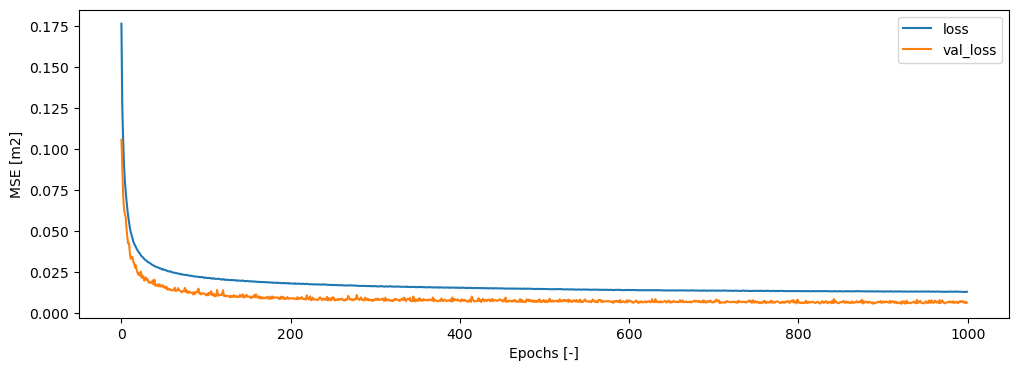

In [8]:
fig, ax = plt.subplots(figsize = (12, 4))
dfhist[['loss', 'val_loss']].plot(ax = ax)
ax.set_xlabel('Epochs [-]')
ax.set_ylabel('MSE [m2]')
fig.savefig(pathOut/f'trainValCurve_{modelID}_fold{fold}.png', dpi = 100, 
            bbox_inches = 'tight')

In [9]:
predictions = callback.best_model.predict(X_val2)

492/492 [==============================] - 3s 5ms/step


In [10]:
dfVal = pd.DataFrame(y_val.reshape(y_val.shape[:2]), columns = NOAAstations)
dfPred = pd.DataFrame(predictions, columns = [f'{x}_pred' for x in NOAAstations])
dfAll = pd.concat([dfVal, dfPred], axis = 1)
dfAll.to_csv(pathOut/f'predValSet_{modelID}.csv')

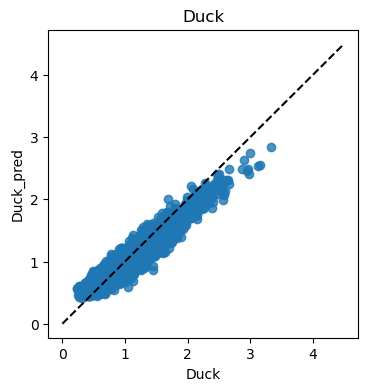

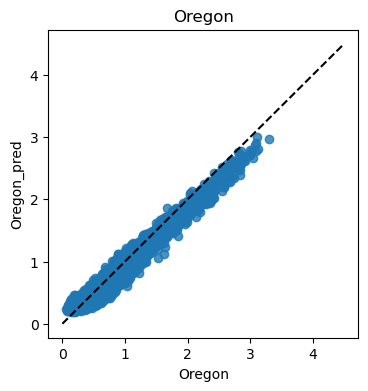

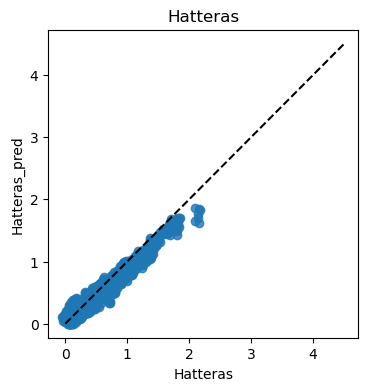

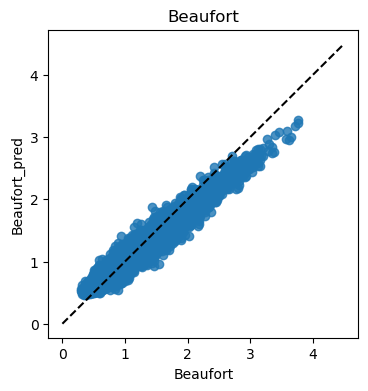

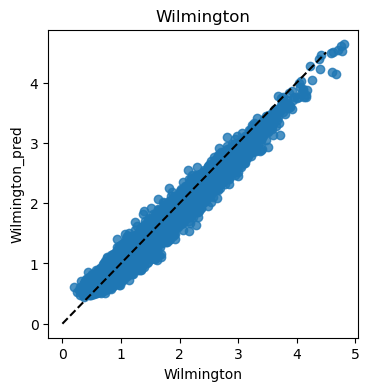

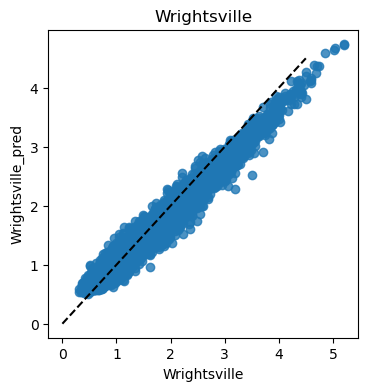

In [11]:
for i in range(6):
    fig, ax = plt.subplots(figsize = (4,4))
    sns.regplot(x = dfVal.iloc[:, i], y = dfPred.iloc[:, i], ax = ax, fit_reg = False)
    ax.plot(np.arange(0, 5, 0.5), np.arange(0, 5, 0.5), ls = '--', c = 'k')
    ax.set_title(f'{NOAAstations[i]}')
    fig.savefig(pathOut/f'predValSet_{modelID}_{NOAAstations[i]}.png',
                dpi = 100, bbox_inches = 'tight')

In [9]:
#### delete model
tf.keras.backend.clear_session()
del model
del optimizer
del callback